In [1]:
# TUGAS UAS KELOMPOK
## Mata Kuliah: TIF505 – Big Data

### Kelompok 7
# **Judul:** Analisis Penjualan Produk E-Commerce Menggunakan PySpark

# **Anggota Kelompok:**
# 1. Muhammad Maulana
# 2. Sena Dwi Ilham Santoso
# 3. Denta Pramudya
# 4. Arjuna Surya Esha Darmawan

In [2]:
# ============================================
# 1. SETUP JAVA UNTUK PYSPARK
# ============================================


# Install Java Development Kit (JDK) versi 11
!sudo apt install openjdk-11-jdk -y

# Import library os untuk mengatur environment variable
import os

# Menentukan lokasi instalasi Java
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"

# Menambahkan Java ke PATH sistem agar dikenali oleh PySpark
os.environ["PATH"] += os.pathsep + os.environ["JAVA_HOME"] + "/bin"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  ca-certificates-java fonts-dejavu-extra java-common libatk-wrapper-java
  libatk-wrapper-java-jni libice-dev libnspr4 libnss3 libpcsclite1
  libpthread-stubs0-dev libsm-dev libx11-dev libxau-dev libxcb1-dev
  libxdmcp-dev libxt-dev openjdk-11-jdk-headless openjdk-11-jre
  openjdk-11-jre-headless x11proto-dev xorg-sgml-doctools xtrans-dev
Suggested packages:
  default-jre libice-doc pcscd libsm-doc libx11-doc libxcb-doc libxt-doc
  openjdk-11-demo openjdk-11-source visualvm libnss-mdns fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei | fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  ca-certificates-java fonts-dejavu-extra java-common libatk-wrapper-java
  libatk-wrapper-java-jni libice-dev libnspr4 libnss3 libpcsclite1
  libpthread-stubs0-dev libsm-dev libx11-dev libxau-dev libxcb1-dev
  libxdmc

In [3]:
# ============================================
# 2. IMPORT LIBRARY & INISIALISASI SPARK
# ============================================

# Import SparkSession sebagai entry point PySpark
from pyspark.sql import SparkSession

# Import fungsi PySpark untuk manipulasi data
from pyspark.sql.functions import col, to_date, year, sum as _sum

# Membuat SparkSession
spark = (
    SparkSession.builder
    .appName("AnalisisPenjualanECommerce")
    .master("local[*]")
    .getOrCreate()
)

# Mengatur level log agar output tidak terlalu banyak
spark.sparkContext.setLogLevel("WARN")

# Menampilkan informasi SparkSession
spark


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/12/24 08:02:30 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
# ============================================
# 3. DATA INGESTION (MEMBACA DATASET)
# ============================================

# Membaca file CSV menggunakan Apache Spark
df = spark.read.csv(
    "Ecommerce_Sales_Data_2024_2025.csv",  # Nama file dataset
    header=True,                           # Baris pertama adalah header
    inferSchema=True                      # Spark mendeteksi tipe data otomatis
)

# Menampilkan struktur kolom dan tipe datanya
df.printSchema()

# Menampilkan 5 baris pertama dataset
df.show(5)

root
 |-- Order ID: integer (nullable = true)
 |-- Order Date: date (nullable = true)
 |-- Customer Name: string (nullable = true)
 |-- Region: string (nullable = true)
 |-- City: string (nullable = true)
 |-- Category: string (nullable = true)
 |-- Sub-Category: string (nullable = true)
 |-- Product Name: string (nullable = true)
 |-- Quantity: integer (nullable = true)
 |-- Unit Price: integer (nullable = true)
 |-- Discount: integer (nullable = true)
 |-- Sales: double (nullable = true)
 |-- Profit: double (nullable = true)
 |-- Payment Mode: string (nullable = true)

+--------+----------+-------------+------+---------+---------+------------+-----------------+--------+----------+--------+--------+--------+------------+
|Order ID|Order Date|Customer Name|Region|     City| Category|Sub-Category|     Product Name|Quantity|Unit Price|Discount|   Sales|  Profit|Payment Mode|
+--------+----------+-------------+------+---------+---------+------------+-----------------+--------+----------+-

In [5]:
# ============================================
# 4. DATA PREPROCESSING
# ============================================

# Mengubah Order Date menjadi format tanggal
df_clean = df.withColumn(
    "Order Date",
    to_date(col("Order Date"), "yyyy-MM-dd")
)

# Menghapus data kosong pada kolom penting
df_clean = df_clean.dropna(
    subset=["Order Date", "Product Name", "Category", "Region", "Quantity", "Sales", "Profit"]
)

df_clean.show(5)

+--------+----------+-------------+------+---------+---------+------------+-----------------+--------+----------+--------+--------+--------+------------+
|Order ID|Order Date|Customer Name|Region|     City| Category|Sub-Category|     Product Name|Quantity|Unit Price|Discount|   Sales|  Profit|Payment Mode|
+--------+----------+-------------+------+---------+---------+------------+-----------------+--------+----------+--------+--------+--------+------------+
|   10001|2024-10-19| Kashvi Varty| South|Bangalore|    Books| Non-Fiction|Non-Fiction Ipsum|       2|     36294|       5| 68958.6|10525.09|  Debit Card|
|   10002|2025-08-30|  Advik Desai| North|    Delhi|Groceries|        Rice|        Rice Nemo|       1|     42165|      20| 33732.0| 6299.66|  Debit Card|
|   10003|2023-11-04|   Rhea Kalla|  East|    Patna|  Kitchen|      Juicer|      Juicer Odio|       4|     64876|      20|207603.2|19850.27| Credit Card|
|   10004|2025-05-23|    Anika Sen|  East|  Kolkata|Groceries|         Oil| 

In [6]:
# ============================================
# 5. Produk Paling Banyak Terjual
# ============================================

produk_terlaris = (
    df_clean
    .groupBy("Product Name")
    .agg(_sum("Quantity").alias("TotalTerjual"))
    .orderBy(col("TotalTerjual").desc())
)

produk_terlaris.show(10)

[Stage 4:>                                                          (0 + 1) / 1]

+--------------------+------------+
|        Product Name|TotalTerjual|
+--------------------+------------+
| Microwave Provident|          17|
|           Lamp Enim|          16|
| Kids Wear Accusamus|          15|
|       Board Game Ab|          15|
|  Women's Wear Optio|          15|
|        Lamp Nostrum|          15|
|          Sofa Nobis|          14|
|Headphones Accusa...|          14|
|         Puzzle Illo|          14|
|      Wall Art Saepe|          14|
+--------------------+------------+
only showing top 10 rows



In [7]:
# ============================================
# 6. Total Penjualan per Kategori
# ============================================

penjualan_kategori = (
    df_clean
    .groupBy("Category")
    .agg(_sum("Sales").alias("TotalSales"))
    .orderBy(col("TotalSales").desc())
)

penjualan_kategori.show()


+-----------+--------------------+
|   Category|          TotalSales|
+-----------+--------------------+
| Home Decor| 5.723322234999998E7|
|  Furniture| 5.664718790000004E7|
|   Clothing| 5.505390829999999E7|
|      Books| 5.493264299999994E7|
|    Kitchen| 5.422790230000004E7|
|Electronics| 5.258788394999998E7|
|       Toys|5.2227366449999996E7|
|     Sports| 5.206939725000003E7|
|     Beauty|5.0803409699999966E7|
|  Groceries|       4.788310315E7|
+-----------+--------------------+



In [8]:
# ============================================
# 7. Total Penjualan per Region
# ============================================


penjualan_region = (
    df_clean
    .groupBy("Region")
    .agg(_sum("Sales").alias("TotalSales"))
    .orderBy(col("TotalSales").desc())
)

penjualan_region.show()


+------+--------------------+
|Region|          TotalSales|
+------+--------------------+
| North|1.4357824610000005E8|
|  East|1.3581163794999996E8|
|  West|1.3104597334999998E8|
| South|1.2323016695000012E8|
+------+--------------------+



In [9]:
# ============================================
# 8. VISUALISASI DATA (PYTHON)
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

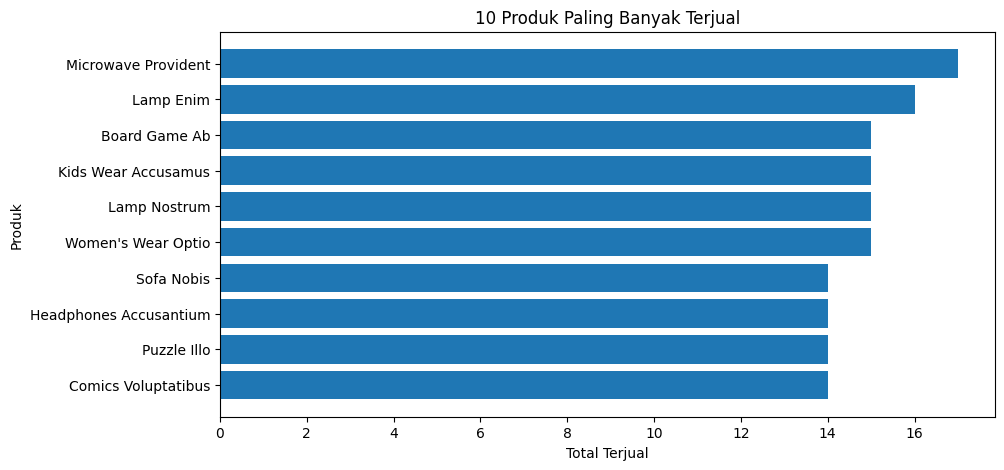

In [10]:
# ============================================
# 9. Bar Chart – Produk Terlaris
# ============================================

pdf_produk = produk_terlaris.limit(10).toPandas()

plt.figure(figsize=(10,5))
plt.barh(pdf_produk["Product Name"], pdf_produk["TotalTerjual"])
plt.title("10 Produk Paling Banyak Terjual")
plt.xlabel("Total Terjual")
plt.ylabel("Produk")
plt.gca().invert_yaxis()
plt.show()


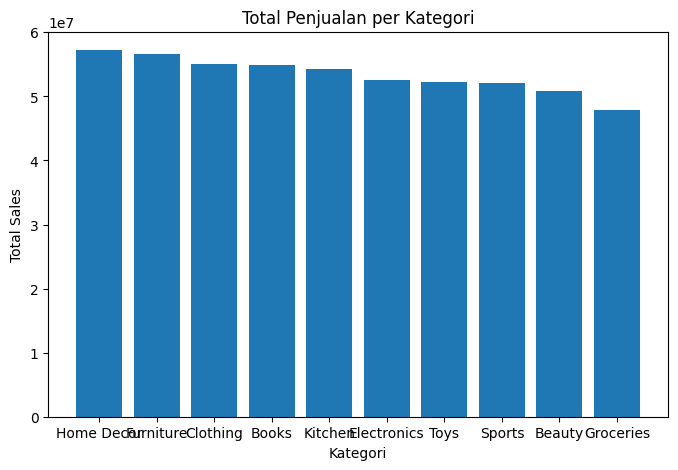

In [11]:
# ============================================
# 10. Bar Chart – Sales per Kategori
# ============================================

pdf_kategori = penjualan_kategori.toPandas()

plt.figure(figsize=(8,5))
plt.bar(pdf_kategori["Category"], pdf_kategori["TotalSales"])
plt.title("Total Penjualan per Kategori")
plt.xlabel("Kategori")
plt.ylabel("Total Sales")
plt.show()


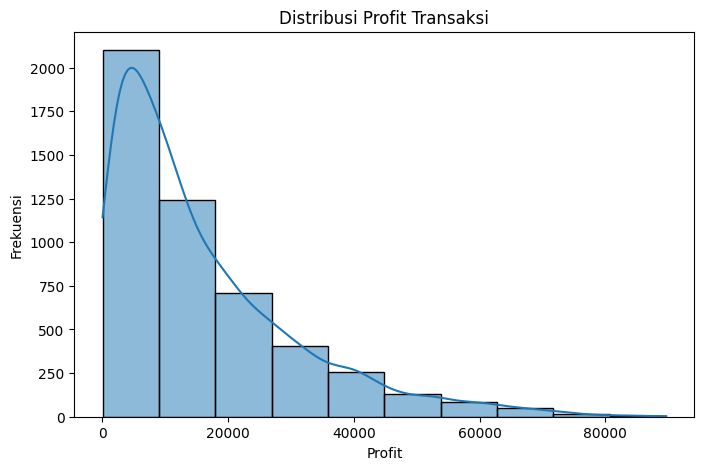

In [12]:
# ============================================
# 11. Histogram – Distribusi Profit
# ============================================


pdf_profit = df_clean.select("Profit").toPandas()

plt.figure(figsize=(8,5))
sns.histplot(pdf_profit["Profit"], bins=10, kde=True)
plt.title("Distribusi Profit Transaksi")
plt.xlabel("Profit")
plt.ylabel("Frekuensi")
plt.show()


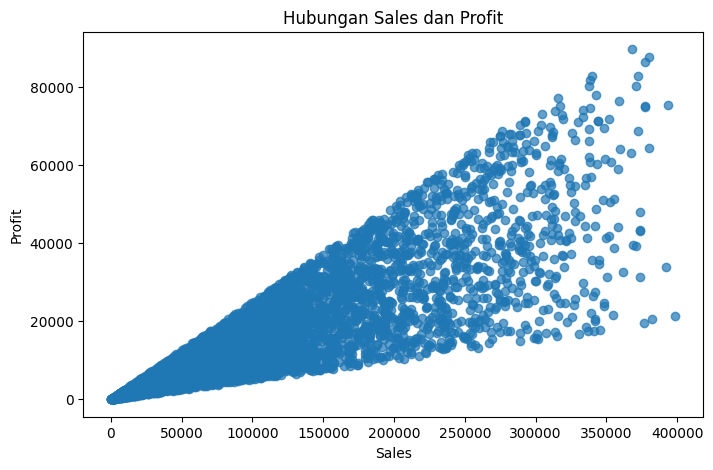

In [13]:
# ============================================
# 12. Scatter Plot – Sales vs Profit
# ============================================


pdf_sales_profit = df_clean.select("Sales", "Profit").toPandas()

plt.figure(figsize=(8,5))
plt.scatter(pdf_sales_profit["Sales"], pdf_sales_profit["Profit"], alpha=0.7)
plt.title("Hubungan Sales dan Profit")
plt.xlabel("Sales")
plt.ylabel("Profit")
plt.show()

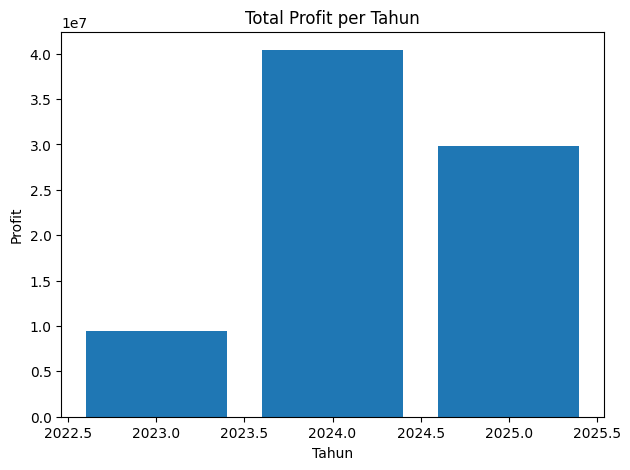

In [14]:
# ============================================
# 13. Profit per Tahun
# ============================================


df_tahun = df_clean.withColumn("Tahun", year(col("Order Date")))

profit_tahun = (
    df_tahun
    .groupBy("Tahun")
    .agg(_sum("Profit").alias("TotalProfit"))
    .orderBy("Tahun")
)

pdf_profit_tahun = profit_tahun.toPandas()

plt.figure(figsize=(7,5))
plt.bar(pdf_profit_tahun["Tahun"], pdf_profit_tahun["TotalProfit"])
plt.title("Total Profit per Tahun")
plt.xlabel("Tahun")
plt.ylabel("Profit")
plt.show()

In [15]:
# ============================================
# 14. ANALISIS LANJUTAN (K-MEANS)
# ============================================

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans

data_cluster = penjualan_kategori.withColumnRenamed("TotalSales", "nilai")

assembler = VectorAssembler(inputCols=["nilai"], outputCol="features")
data_ready = assembler.transform(data_cluster)

kmeans = KMeans(k=3, seed=42)
model = kmeans.fit(data_ready)

hasil_cluster = model.transform(data_ready)
hasil_cluster.show()

25/12/24 08:03:11 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
                                                                                

+-----------+--------------------+--------------------+----------+
|   Category|               nilai|            features|prediction|
+-----------+--------------------+--------------------+----------+
| Home Decor| 5.723322234999998E7|[5.72332223499999...|         0|
|  Furniture| 5.664718790000004E7|[5.66471879000000...|         0|
|   Clothing| 5.505390829999999E7|[5.50539082999999...|         0|
|      Books| 5.493264299999994E7|[5.49326429999999...|         0|
|    Kitchen| 5.422790230000004E7|[5.42279023000000...|         0|
|Electronics| 5.258788394999998E7|[5.25878839499999...|         1|
|       Toys|5.2227366449999996E7|[5.22273664499999...|         1|
|     Sports| 5.206939725000003E7|[5.20693972500000...|         1|
|     Beauty|5.0803409699999966E7|[5.08034096999999...|         1|
|  Groceries|       4.788310315E7|     [4.788310315E7]|         2|
+-----------+--------------------+--------------------+----------+



In [16]:
# ============================================
# 15. SPARK SQL
# ============================================

df_clean.createOrReplaceTempView("ecommerce")

spark.sql("""
SELECT Category, AVG(Profit) AS RataRataProfit
FROM ecommerce
GROUP BY Category
ORDER BY RataRataProfit DESC
""").show()


+-----------+------------------+
|   Category|    RataRataProfit|
+-----------+------------------+
|Electronics|17038.419237288137|
|       Toys| 16708.93606694561|
| Home Decor|16615.236776699036|
|   Clothing|16527.887064579252|
|  Furniture|16495.421309297893|
|     Beauty| 15681.38276086956|
|      Books|15295.972140151533|
|     Sports|15145.655655577295|
|  Groceries|15053.899234042545|
|    Kitchen|14923.434261363629|
+-----------+------------------+



In [17]:
# ============================================
# EXPORT DATA UNTUK DASHBOARD
# ============================================

pdf_produk.to_csv("produk_terlaris.csv", index=False)
pdf_profit_tahun.to_csv("profit_per_tahun.csv", index=False)


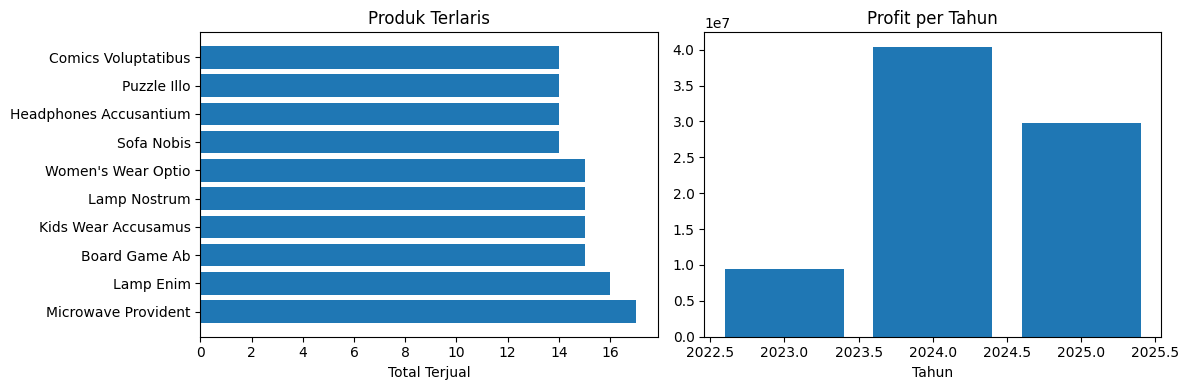

In [18]:
# ============================================
# DASHBOARD
# ============================================

import pandas as pd
import matplotlib.pyplot as plt

# Load data hasil analisis
produk = pd.read_csv("produk_terlaris.csv")
profit = pd.read_csv("profit_per_tahun.csv")

plt.figure(figsize=(12,4))

# Grafik Produk Terlaris
plt.subplot(1,2,1)
plt.barh(produk["Product Name"], produk["TotalTerjual"])
plt.title("Produk Terlaris")
plt.xlabel("Total Terjual")

# Grafik Profit per Tahun
plt.subplot(1,2,2)
plt.bar(profit["Tahun"], profit["TotalProfit"])
plt.title("Profit per Tahun")
plt.xlabel("Tahun")

plt.tight_layout()
plt.show()
